In [ ]:

!pip install -qU datasets fsspec huggingface_hub transformers gradio scikit-learn matplotlib
import os; os.kill(os.getpid(),9)   # restart runtime to pick up upgrades

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 121.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 123.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.


In [1]:
!pip install transformers datasets gradio scikit-learn nltk matplotlib

import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
from datasets import load_dataset
from transformers import BertForSequenceClassification, BertTokenizerFast, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
pip install datasets

In [3]:
from datasets import load_dataset

In [5]:
from datasets import load_dataset
dataset = load_dataset("cybersectony/PhishingEmailDetectionv2.0")
train_ds      = dataset["train"]        # 120 K
val_ds        = dataset["validation"]   #  20 K
test_ds       = dataset["test"]         #  60 K

README.md:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/27.9M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/3.17M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/9.21M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60000 [00:00<?, ? examples/s]

In [10]:
DEV_TRAIN_SIZE = 10000   # 10–20 K for fast iterations
DEV_VAL_SIZE   =  2500

small_train = train_ds.shuffle(seed=42).select(range(DEV_TRAIN_SIZE))
small_val   = val_ds.shuffle(seed=42).select(range(DEV_VAL_SIZE))

print(f"Dev train size: {len(small_train)}, Dev val size: {len(small_val)}")

Dev train size: 10000, Dev val size: 2500


In [11]:

# 2) Tokenize (exactly as before)
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["content"], truncation=True, padding="max_length", max_length=64)

small_train = small_train.map(tokenize, batched=True)
small_val   = small_val.map(tokenize, batched=True)

small_train.set_format("torch", columns=["input_ids","attention_mask","label"])
small_val.set_format(  "torch", columns=["input_ids","attention_mask","label"])



Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

In [15]:
# 3) Fine-tune on train + validate on val
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

def compute_metrics(pred):
    labels = pred.label_ids
    preds  = np.argmax(pred.predictions, axis=1)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}


training_args = TrainingArguments(
    output_dir="phish_dev_ckpt",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    fp16=True,
    eval_steps=2500,      # run validation every ~2 500 steps (~1 epoch on 20 K samples)
    logging_steps=500,    # log training loss every 500 steps
    report_to=[],         # disable W&B
    logging_dir="phish_logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train,
    eval_dataset=small_val,
    compute_metrics=compute_metrics,
)

trainer.train()



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.146000
1000,0.061100
1500,0.046100
2000,0.028000
2500,0.025200
3000,0.018800
3500,0.012900


TrainOutput(global_step=3750, training_loss=0.0464538407643636, metrics={'train_runtime': 778.476, 'train_samples_per_second': 38.537, 'train_steps_per_second': 4.817, 'total_flos': 986684175360000.0, 'train_loss': 0.0464538407643636, 'epoch': 3.0})

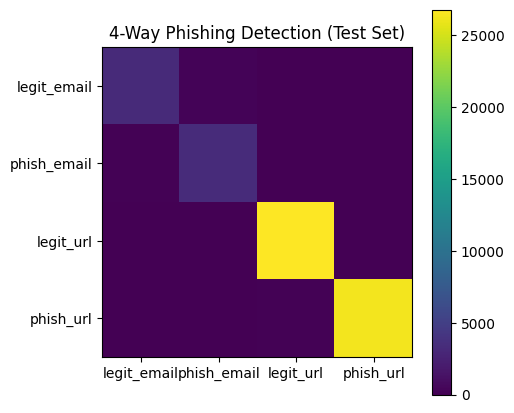

              precision    recall  f1-score   support

 legit_email       0.96      0.94      0.94      3370
 phish_email       0.94      0.96      0.95      3429
   legit_url       1.00      1.00      1.00     26760
   phish_url       1.00      1.00      1.00     26441

    accuracy                           0.99     60000
   macro avg       0.97      0.97      0.97     60000
weighted avg       0.99      0.99      0.99     60000



In [16]:
# 4) Final evaluation on the untouched test set
eval_output = trainer.predict(test_ds)
preds  = np.argmax(eval_output.predictions, axis=1)
labels = eval_output.label_ids

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation="nearest")
plt.xticks([0,1,2,3], ["legit_email","phish_email","legit_url","phish_url"])
plt.yticks([0,1,2,3], ["legit_email","phish_email","legit_url","phish_url"])
plt.colorbar()
plt.title("4-Way Phishing Detection (Test Set)")
plt.show()

print(classification_report(labels, preds,
      target_names=["legit_email","phish_email","legit_url","phish_url"]))


In [17]:
# Save model
model.save_pretrained("saved_model")
tokenizer.save_pretrained("saved_model")
print("Checkpoint & tokenizer saved to ./saved_model")


Checkpoint & tokenizer saved to ./saved_model


In [18]:
import gradio as gr
import torch
from transformers import BertForSequenceClassification, BertTokenizerFast

# Load back your saved checkpoint
model = BertForSequenceClassification.from_pretrained("saved_model")
tokenizer = BertTokenizerFast.from_pretrained("saved_model")
model.eval()

# Map label IDs → human labels
label_map = {
    0: "Legit Email 📧",
    1: "Phishing Email 🚩",
    2: "Legit URL 🔗",
    3: "Phishing URL ⚠️"
}

def predict_phish(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=64)
    with torch.no_grad():
        logits = model(**inputs).logits
    return label_map[int(logits.argmax(dim=1))]

# Build & launch the interface
demo = gr.Interface(
    fn=predict_phish,
    inputs=gr.Textbox(lines=2, placeholder="Paste an email body or URL here…"),
    outputs="text",
    title="4-Way Phishing Detector",
    description="Classifies text/URLs as legit vs. phishing (email/URL)."
)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://301fe4ea023100fbc0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
